Current Time = 08:21:47

************************************************************
use_gpu = 1, use_hash=1, use_thread = 0
calc_psnr use_gpu = 1
calc_psnr use_gpu = 1
calc_psnr use_gpu = 1
calc_psnr use_gpu = 1
calc_psnr use_gpu = 1
calc_psnr use_gpu = 1

Plotting .... 


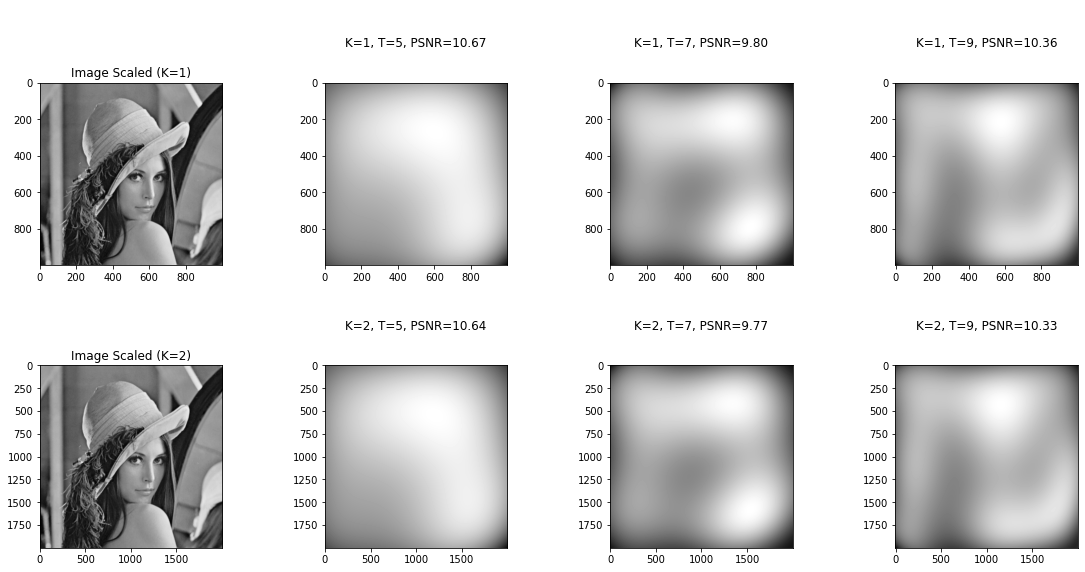


Done.
Wall time: 8.36 s


In [18]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

# 차수에 따른 연산 속도 

print_curr_time()

def test_moment_restore(img_infos, img_input, Ks, Ts, **options) :
    print( line2 )
    print( f"use_gpu = { options['use_gpu'] }, use_hash={ options['use_hash'] }, use_thread = { options['use_thread'] }" )
    
    use_gpu = get_option( "use_gpu", **options )

    for K in Ks : 
        options[ "hash" ] = {}

        circle_type = "outer"

        rho, theta, x, y, dx, dy, k, area = rho_theta( 1000*K, circle_type, **options ) 

        img = cv.resize( img_input, (int(K*1_000), int(K*1_000)), interpolation=cv.INTER_AREA )
        
        np = cupy if use_gpu else numpy
        
        if use_gpu :
            img = cupy.asarray( img )
        pass

        # image scaled
        img_infos.append( { "title" : f"Image Scaled (K={K})", "img" : img } )

        for T in Ts : 

            moments, run_time = calc_moments(T, img, rho, theta, dx, dy, **options )
            img_restored, run_time2 = restore_image(moments, rho, theta, **options )
            
            t_img = img_restored.real
            psnr = calc_psnr( img, t_img, **options )
            img_infos.append( { "title" : f"K={K}, T={T}", "img" : t_img, "psnr" : psnr } ) 
        pass
        
        if "hash" in options : 
            del options[ "hash" ]
        pass
    pass
pass # test_moment_restore

options = {}
options[ "debug" ] = 0 
options[ "use_gpu" ] = 1
options[ "hash" ] = {}
options[ "use_hash" ] = 1  
options[ "use_thread"] = 0 

img_infos = []
    
Ks = numpy.arange( 1, 3, 1 )
Ts = numpy.arange( 5, 11, 2 )

img = cv.imread( 'image/lenna.png', 0 )
        
test_moment_restore( img_infos, img, Ks, Ts, **options )

print( "\nPlotting .... ")
    
# 서브 챠트 생성 
col_cnt = len(Ks) if len(Ks) > len(Ts) else len(Ts)
col_cnt += 1 

row_cnt = len( img_infos ) // col_cnt
if col_cnt*row_cnt < len( img_infos ) :
    row_cnt += 1
pass

fig, charts = plt.subplots( row_cnt, col_cnt, figsize=(4*col_cnt, 4*row_cnt) )
charts = charts.ravel() if row_cnt*col_cnt > 1 else [charts]
chart_idx = 0 

for img_info in img_infos : 
    t_img = img_info[ "img" ]
    title = img_info[ "title" ]
    title_low = title.lower()
    
    if "psnr" in img_info : 
        psnr = img_info[ "psnr"]
        
        title = f"\n{title}, PSNR={psnr:.2f}\n" 
        title = f"\n{title}\n"
    pass
        
    colorbar = False 
    if "colorbar" in img_info :
        colorbar = img_info[ "colorbar" ]

    chart = charts[ chart_idx ] ; chart_idx += 1
    
    chart.set_title( title )
    
    pos = chart.imshow( cupy.asnumpy( t_img ) if options["use_gpu"] else t_img, cmap='gray' )
    colorbar and fig.colorbar(pos, ax=chart)
pass

# draw empty chart
for chart_idx in range( chart_idx, len(charts) ) :
    chart = charts[ chart_idx ]
    chart.plot( [0,0], [0,0] )
    chart.set_axis_off()
pass

plt.tight_layout(); plt.show() 

del options

print( "\nDone." )